Tentativa de reproducao da rede neural proposta em https://doi.org/10.1016/j.physa.2018.07.017

In [18]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(12,40)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(40,30)
        self.linear3 = nn.Linear(30,20)
        self.linear4 = nn.Linear(20,10)
        self.linear5 = nn.Linear(10,5)
        self.linear6 = nn.Linear(5,4)
        self.output_layer = nn.Linear(4,4)
        self.softmax = nn.Softmax()
        self.layer_list = [self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6]

    # x represents our data
    def forward(self, x):
        for layer in self.layer_list:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        output = self.softmax(x)
        return output
    
model = Net()



In [2]:
df = pd.read_csv(r'data\binance\2016.7.31_2019.1.24\bitcoin_15m_2016.7.31_2019.1.24.csv')
df['return'] = df['close'].pct_change(1)


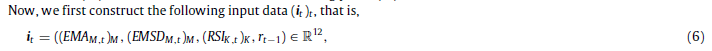

In [3]:
returns_avg = df['return'].mean()
returns_stdev = df['return'].std()
df['norm_return'] = (df['return']-returns_avg)/returns_stdev
df['prev_return'] = df['norm_return'].shift()


In [4]:
df = df.dropna().reset_index(drop=True)

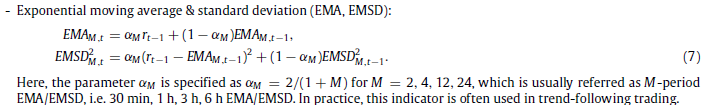

In [5]:
M = [2,4,12,24]
for m in M:
    df[f"a{m}"] = 2/(1+m)

In [6]:
for idx,row in tqdm(df.iterrows()):
    if idx==0:
        for m in M:
            df.loc[idx,f'EMA{m}'] = 0
            df.loc[idx,f'EMSD{m}'] = 0
    else:
        for m in M:
            df.loc[idx,f'EMA{m}'] = row[f'a{m}']*row['prev_return'] + (1-row[f'a{m}'])*df.loc[idx-1,f'EMA{m}']
            df.loc[idx,f'EMSD{m}'] = np.sqrt(row[f'a{m}']*(row['prev_return']-df.loc[idx-1,f'EMA{m}'])**2 + (1-row[f'a{m}'])*(df.loc[idx-1,f'EMSD{m}']**2))

50118it [00:53, 942.97it/s]


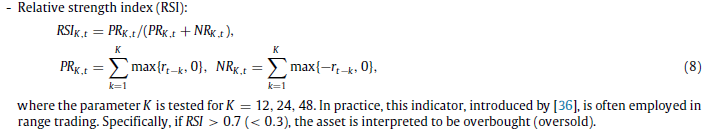

In [7]:
K = [12,24,48]

In [8]:
for idx,row in tqdm(df.iterrows()):
    if idx >= max(K):
        for k in K:
            values = df.loc[idx-k:idx-1, 'prev_return']
            maxes = []
            negative_maxes = []
            for val in values:
                negative = max(-1*val,0)
                biggest = max(0,val)
                maxes.append(biggest)
                negative_maxes.append(negative)
            df.loc[idx,f'PR{k}'] = sum(maxes)
            df.loc[idx,f'NR{k}'] = sum(negative_maxes)
            

50118it [00:40, 1226.43it/s]


In [9]:
for k in K:
    df[f"RSI{k}"] = df[f"PR{k}"]/(df[f"PR{k}"]+df[f"NR{k}"])


In [10]:
# df = df.loc[100:]
df = df.reset_index(drop=True)

In [20]:
training_to_test_ratio = .73
train_test_idx_split = int(df.shape[0]*training_to_test_ratio)
returns = df.loc[:train_test_idx_split, 'norm_return']
percentiles=[25,50,75]
percentile_values = np.percentile(returns, percentiles)

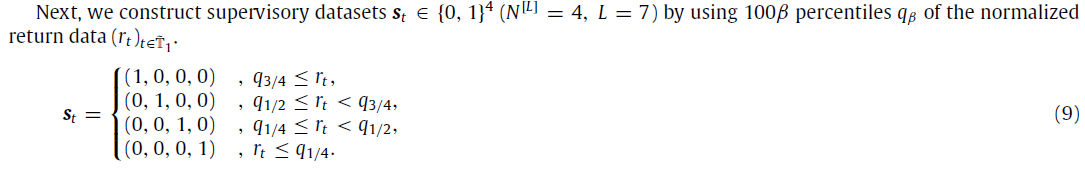

In [21]:
classes = []
for idx,row in df.iterrows():
    rt = row['norm_return']
    if rt >= percentile_values[2]:
        classes.append('high')
    elif rt >= percentile_values[1] and rt < percentile_values[2]:
        classes.append('medium-high')
    elif rt >= percentile_values[0] and rt < percentile_values[1]:
        classes.append('medium-low')
    elif rt <= percentile_values[0]:
        classes.append('low')
classes_dict = {
    'high':[1,0,0,0],
    'medium-high':[0,1,0,0],
    'medium-low':[0,0,1,0],
    'low':[0,0,0,1]
}

In [23]:
labels = pd.DataFrame([classes_dict[classe] for classe in classes], columns=['high','medium-high', 'medium-low', 'low'])
#save labels
labels.to_csv(r'data\ann_data\labels.csv', index=False)

In [17]:
input_data = df[['EMA2', 'EMA4', 'EMA12', 'EMA24', 'EMSD2', 'EMSD4', 'EMSD12', 'EMSD24', 'RSI12', 'RSI24', 'RSI48', 'prev_return']]
#save input data
input_data.to_csv(r'data\ann_data\input_data.csv', index=False)